In [1]:
import os
import pandas as pd
new_shot_df = pd.read_csv("./dataset/KSTAR_Disruption_Shot_List_extend.csv", encoding = "euc-kr")

In [2]:
new_shot_df.head()

,shot,year,tftsrt,tipminf,tTQend,dt,frame_cutoff,frame_tTQend,frame_tipminf
0,21273,2018,2.996,5.535,5.514,0.021,1165,1160,1164
1,21274,2018,2.996,10.056,10.038,0.018,2104,2100,2103
2,21310,2018,1.500,5.368,5.342,0.026,1131,1125,1130
3,21315,2018,1.500,7.804,7.782,0.022,1636,1631,1635
4,21317,2018,1.500,9.460,9.438,0.022,1980,1975,1979


In [3]:
import pytesseract
from PIL import Image
pytesseract.image_to_string(Image.open('./dataset/dur21_dis0/test/disruption/21325_1369_1390/0000.jpg'))


' \n\n'

In [66]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import cv2
from src.utils.utility import crop, normalize
from tqdm.auto import tqdm
import gc
import numpy as np
from PIL import Image
import pytesseract
import time

resize_height = 96
resize_width = 768
fps = 210
eps = 0.075

def check_cutoff(frame : np.ndarray, thres : float = eps):
    mean = np.mean(frame)
    if mean < thres:
        return True
    else:
        return False

def norm(img : np.ndarray):
    img = img.astype(np.float32)
    img /= 255.
    return img

for _, row in tqdm(new_shot_df.iloc[0:1].iterrows()):
    shot_num = row['shot']
    tftsrt = row['tftsrt']

    frame_cutoff = row['frame_cutoff']
    frame_srt = int(tftsrt * fps + 0.1 * fps)
    
    video_dir = os.path.join("./dataset/raw_videos/raw_videos/", "%06dtv01.avi"%shot_num)

    if not os.path.exists(video_dir):
        video_dir = os.path.join("./dataset/raw_videos/raw_videos/", "%06dtv02.avi"%shot_num)

    capture = cv2.VideoCapture(video_dir)
    frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))

    count = 0
    channels = 3
    retaining = True

    start_time = time.time()

    while (count < frame_count and retaining):
        retaining, frame = capture.read()

        if count > frame_srt and count == frame_cutoff:
            break

        if frame is None:
            frame = np.zeros((resize_width, resize_height, channels))

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = cv2.threshold(frame, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        lower = np.array([0, 0, 0])
        upper = np.array([100, 175, 110])
        mask = cv2.inRange(hsv, lower, upper)
        frame = 255 - mask

        # image for fps
        img_fps = frame[:int(0.1 * frame_height), int(0.4 * frame_width):int(0.6 * frame_width)]
        
        # image for time
        img_time = frame[:int(0.1 * frame_height), int(0.6 * frame_width):int(0.9 * frame_width)]
        
        count += 1
        config = '--oem 3 --psm 12'
        # config = 'digits'
        fps = pytesseract.image_to_string(img_fps, lang = 'eng', config = config)
        t = pytesseract.image_to_string(img_time, lang = 'eng', config = config)
        print("fps : {} and time : {}".format(fps, t))
        break

    capture.release()

1it [00:00,  2.35it/s]

fps : am

 and time : a:aa:aa:aa




In [19]:
row = new_shot_df.iloc[1]
shot_num = row['shot']
video_dir = os.path.join("./dataset/raw_videos/raw_videos/", "%06dtv01.avi"%shot_num)
cap = cv2.VideoCapture(video_dir)
print("video : ", video_dir)
print('Frame width:', int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)))
print('Frame height:', int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
print('Frame count:', int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))

fps = cap.get(cv2.CAP_PROP_FPS)
print('FPS:', fps)

video :  ./dataset/raw_videos/raw_videos/021274tv01.avi
Frame width: 640
Frame height: 640
Frame count: 2730
FPS: 5.0


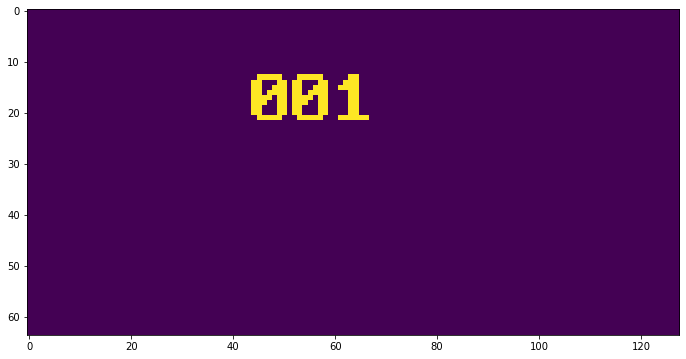

In [64]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,6))
plt.imshow(img_fps)

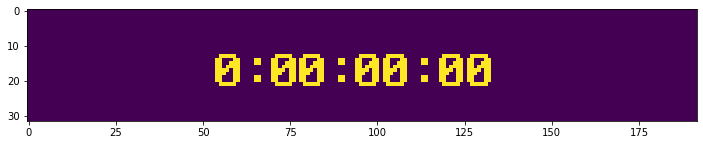

In [59]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,6))
plt.imshow(img_time)

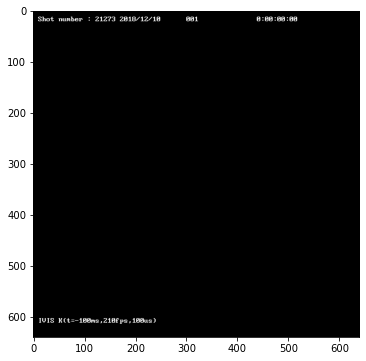

In [60]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,6))
plt.imshow(frame, cmap = 'gray')